# FastAI Transfer Learning

This approach is based on using the fastai libray, copying techniques used in Lesson1 of the fast.ai course 
- https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson1-pets.ipynb

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate
import numpy as np

In [ ]:
import warnings; warnings.simplefilter('ignore')
np.random.seed(2)

### Enable GPU
https://stackoverflow.com/questions/48152674/how-to-check-if-pytorch-is-using-the-gpu

In [ ]:
import torch
torch.cuda.is_available(), torch.cuda.get_device_name(torch.cuda.current_device()), 

In [ ]:
torch.cuda.current_device()

In [ ]:
import GPUtil as GPU
GPUs = GPU.getGPUs()
gpu = GPUs[0]
print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

# Import Data

csv2png.js converts the CSV file into a ImageNet style diretory tree of images
which can be loaded into an ImageDataBunch for use with fastai

In [ ]:
data = ImageDataBunch.from_folder('./data/images/', 
                                  test='test',
                                  valid_pct=0.2,
                                  ds_tfms=get_transforms(do_flip=False),
                                  bs=512
                                 )\
                     .normalize(imagenet_stats)

In [ ]:
data

In [ ]:
data.show_batch(rows=3, figsize=(5,5))

## Establish Baseline: resnet18

Lets start with the smallest network on the list and get some baseline results
- CPU Timings: 02:50 per epoc @ bs=64
- GPU Timings: 01:30 per epoc @ bs=64   (2x improvement) 
- GPU Timings: 01:10 per epoc @ bs=512 
- GPU Timings: 01:10 per epoc @ bs=1024 
- GPU Timings: 01:10 per epoc @ bs=2048 (but lower accuracy) 

In [24]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
# learn.model = learn.model.cpu()   # throws exception
# learn.model = learn.model.cuda()  # is this line required? no effect on speed
learn.fit(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.678779,0.483722,0.840357,01:29
1,0.392425,0.265354,0.914762,01:25


In [25]:
learn.save('resnet18');

In [21]:
def write_csv_predictions(csv_file, learn):
    predictions, *_ = learn.get_preds(DatasetType.Test)
    labels        = np.argmax(predictions, 1)
    submission_df = pd.DataFrame({'ImageId': list(range(1,len(labels)+1)), 'Label': labels})
    submission_df.to_csv(csv_file, index=False)

In [27]:
write_csv_predictions('./submissions/fastai-resnet18-fit2.csv', learn)

### Submit to Kaggle
```
kaggle competitions submit -c digit-recognizer -f ./submissions/fastai-resnet18-fit2.csv -m "fastai: resnet18 + fit(2)"
```

Score: 0.09371 | Rank: 2509/2521

This establishes a baseline score we can attempt to beat

### Add More Epocs

In [28]:
learn.fit(8)
learn.save('resnet18');

epoch,train_loss,valid_loss,accuracy,time
0,0.296057,0.168796,0.945476,01:31
1,0.239199,0.121703,0.963571,01:31
2,0.193459,0.102026,0.966786,01:29
3,0.172979,0.093081,0.970833,01:29
4,0.166506,0.081906,0.972143,01:27
5,0.139234,0.070884,0.976071,01:29
6,0.122924,0.061797,0.979762,01:27
7,0.149596,0.055895,0.982738,01:27


In [29]:
write_csv_predictions('./submissions/fastai-resnet18-fit10.csv', learn)

##### Submit To Kaggle
```
kaggle competitions submit -c digit-recognizer -f ./submissions/fastai-resnet18-fit10.csv -m "fastai: resnet18 + fit(10)"
```
- Score: 0.09614 | Rank: 2517/2529 | ./submissions/fastai-resnet18-fit10.csv

### Learning Rate Finding

We can use learning rate finding and fit_one_cycle to achieve superconvergence if we want to see how far we get resnet18 to converge
https://docs.fast.ai/callbacks.one_cycle.html#What-is-1cycle?

In [36]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


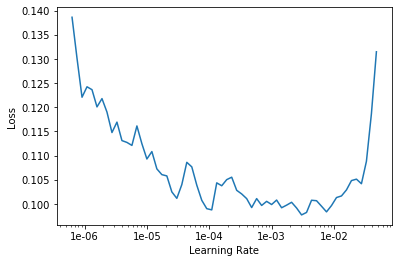

In [37]:
learn.recorder.plot()

In [39]:
learn.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.125553,0.062857,0.981310,01:27
1,0.114590,0.059144,0.979048,01:29
2,0.136303,0.089153,0.970714,01:31
3,0.122263,0.062091,0.981548,01:34
4,0.122282,0.052812,0.982381,01:29
5,0.140062,0.079964,0.974762,01:27
6,0.122094,0.049393,0.985595,01:29
7,0.120679,0.050365,0.984286,01:29
8,0.104096,0.085035,0.972976,01:28
9,0.100259,0.036478,0.989405,01:30


In [40]:
learn.save('resnet18-30');
write_csv_predictions('./submissions/fastai-resnet18-fit_one_cycle_30.csv', learn)

##### Submit To Kaggle
```
kaggle competitions submit -c digit-recognizer -f ./submissions/fastai-resnet18-fit_one_cycle_30.csv -m "fastai: resnet18 + fit_one_cycle(30, 1e-2)"
```
- Score: 0.09614 | Rank: 2517/2529 | ./submissions/fastai-resnet18-fit_one_cycle_30.csv

# Pretrained Neural Networks

There are several other pretrained models to choose from: https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

In [10]:
# dir(models)
model_names = [
 'alexnet',
 'darknet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'squeezenet1_0',
 'squeezenet1_1',
 'unet',
 'vgg11_bn',
 'vgg13_bn',
 'vgg16_bn',
 'vgg19_bn',
 'wrn',
 'wrn_22',
 'xception',
 'xresnet',
 'xresnet101',
 'xresnet152',
 'xresnet18',
 'xresnet34',
 'xresnet50'
]
errors = ['alexnet', 'darknet', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'unet', 'vgg11_bn', 'vgg13_bn', 'vgg16_bn', 'vgg19_bn', 'wrn', 'wrn_22', 'xception', 'xresnet', 'xresnet101', 'xresnet152', 'xresnet18', 'xresnet34', 'xresnet50']
learns = {}

In [12]:
for name in model_names:
    if name in learns.keys(): continue
    if name in errors:        continue
    try:
        print( name )
        model = getattr(models, name)
        learns[name] = cnn_learner(data, model, metrics=accuracy)
        learns[name].lr_find()
    except:
        print( "error: ", name )
        errors.append(name)
        
print( "errors", errors )

errors ['alexnet', 'darknet', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'unet', 'vgg11_bn', 'vgg13_bn', 'vgg16_bn', 'vgg19_bn', 'wrn', 'wrn_22', 'xception', 'xresnet', 'xresnet101', 'xresnet152', 'xresnet18', 'xresnet34', 'xresnet50']


resnet101
resnet152
resnet18
resnet34
resnet50
squeezenet1_0
squeezenet1_1


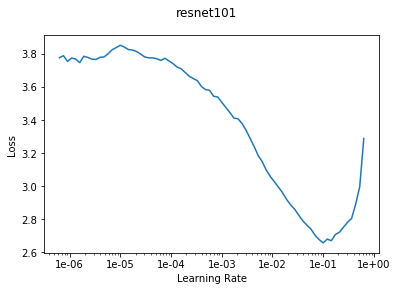

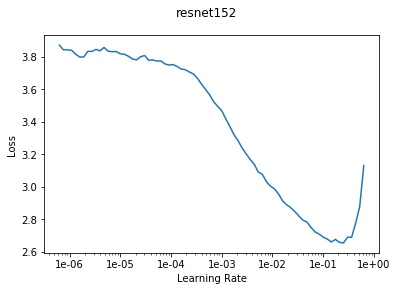

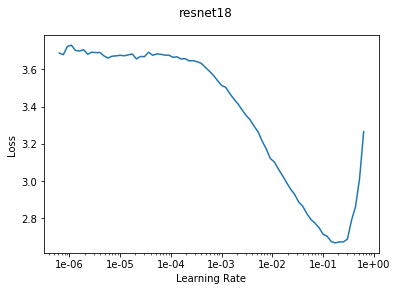

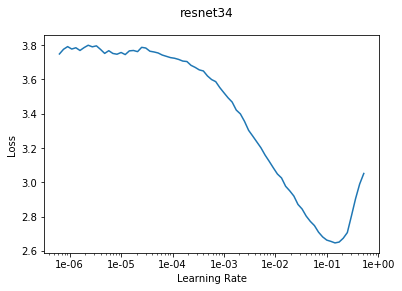

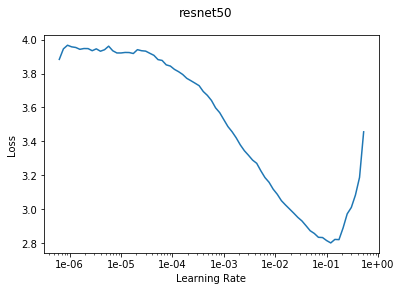

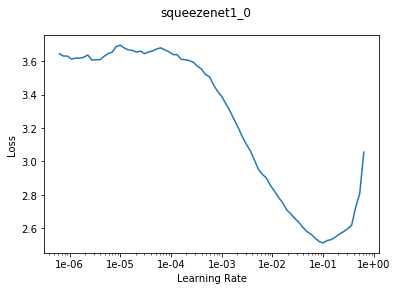

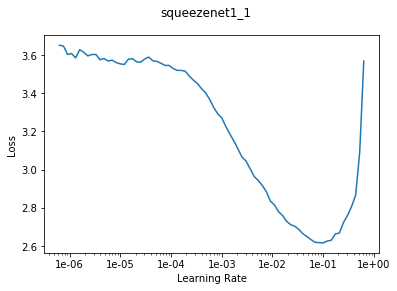

In [18]:
for name in model_names:
    if name in errors: continue
    print( name )        
    learns[name].recorder.plot(return_fig=True).suptitle(name)

It appears that 1e-01 seems to be an suitable max learning rate for all of the above

In [ ]:
for name in model_names:
    if name in errors: continue
    print( name )        
    learns[name].fit_one_cycle(10, slice(1e-3,1e-1))
    learns[name].save(f'{name}-10');
    write_csv_predictions(f'./submissions/fastai-{name}-10.csv', learns[name])    

resnet101


epoch,train_loss,valid_loss,accuracy,time


In [ ]:
for name in model_names:
    if name in errors: continue
    print( name )       
    learns[name].unfreeze()
    learns[name].fit_one_cycle(30, 1e-1)
    learns[name].save(f'{name}-40');
    write_csv_predictions(f'./submissions/fastai-{name}-40.csv', learns[name])    

In [ ]:
for name in model_names:
    if name in errors: continue
    print( name ) 
    learns[name].unfreeze()    
    learns[name].fit_one_cycle(60, 1e-1)
    learns[name].save(f'{name}-100');
    write_csv_predictions(f'./submissions/fastai-{name}-100.csv', learns[name])        